<a href="https://colab.research.google.com/github/reykoki/ML_seismo/blob/main/notebooks/look_at_waveforms_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

In [ ]:
!pip install seisbench

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [1]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Training PhaseNet

This tutorial shows how to train a model with SeisBench, using PhaseNet as an example. This brings together the three main components of SeisBench: data, models and generate.

The tutorial is intended to highlight the basic principles of training models in SeisBench. However, this will not necessarily be best practice for more elaborate experiments. As a reference how to set up larger studies and which augmentations can be used for which models, we refer to the implementation of our pick benchmark at [https://github.com/seisbench/pick-benchmark](https://github.com/seisbench/pick-benchmark).

*Note: As this tutorial brings together different parts of seisbench, it is recommended to go through the basic tutorials first before beginning this tutorial. In addition, this tutorial assumes some familiarity with pytorch*

In [2]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

## Model and data

We create a randomly initialized PhaseNet model using `seisbench.models`. If available, you can move your model onto the GPU for faster training.

In [3]:
model = sbm.PhaseNet(phases="PSN")

model.cuda();

As training data we use the ETHZ dataset. Note that we set the sampling rate to 100 Hz to ensure that all examples are consistent in terms of sampling rate. We split the data into training, development and test sets according to the splits provided.

In [4]:
data = sbd.ETHZ(sampling_rate=100)
train, dev, test = data.train_dev_test()

2022-09-19 18:18:38,905 | seisbench | WARNING | Check available storage and memory before downloading and general use of ETHZ dataset. Dataset size: waveforms.hdf5 ~22Gb, metadata.csv ~13Mb
2022-09-19 18:18:39,585 | seisbench | WARNING | Dataset ETHZ not in cache.
2022-09-19 18:18:39,588 | seisbench | WARNING | Trying to download preprocessed version from SeisBench repository.


## Generation pipeline

The ETHZ dataset contains detailed labels for the phases. However, for this example we only want to differentiate between P and S picks. Therefore, we define a dictionary mapping the detailed picks to their phases.

In [5]:
phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

Now we define two generators with identical augmentations, one for training, one for validation. The augmentations are:
1. Selection of a (long) window around a pick. This way, we ensure that out data always contains a pick.
1. Selection of a random window with 3001 samples, the input length of PhaseNet.
1. A normalization, consisting of demeaning and amplitude normalization.
1. A change of datatype to float32, as this is expected by the pytorch model.
1. A probabilistic label

In [6]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0)
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)

Let's visualize a few training examples. Everytime you run the cell below, you'll see a different training example.

15826


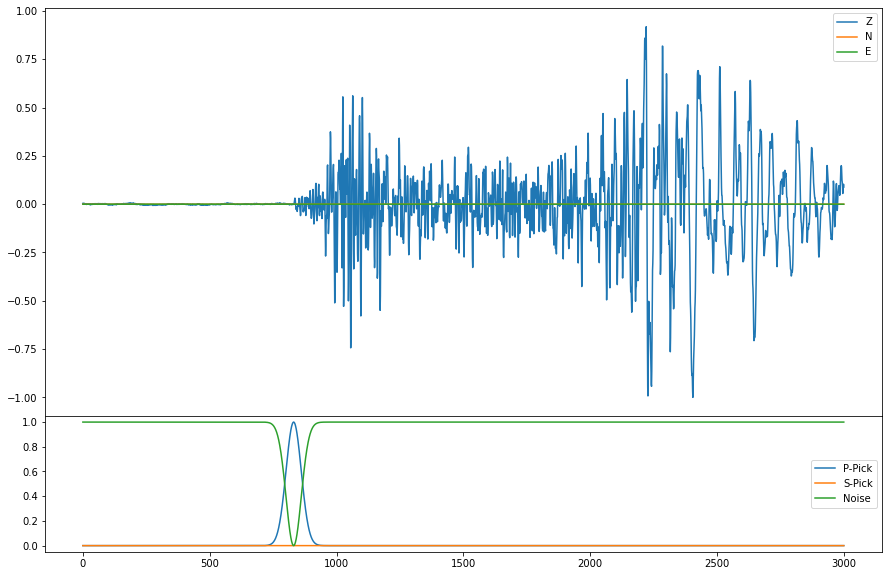

9403


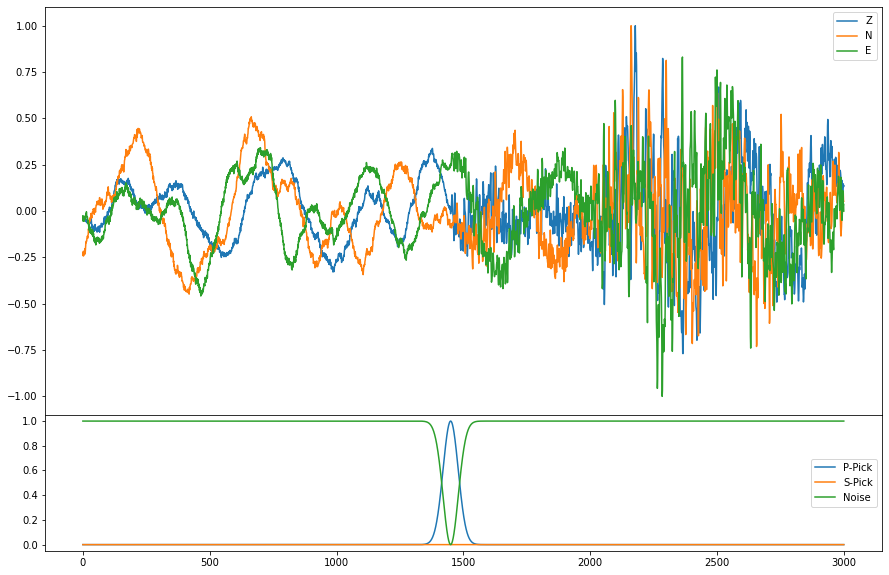

13118


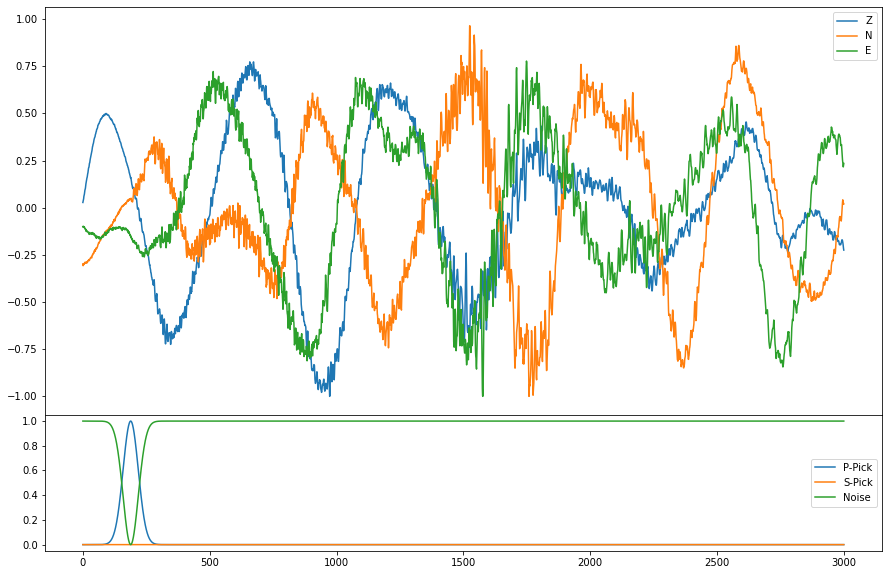

2279


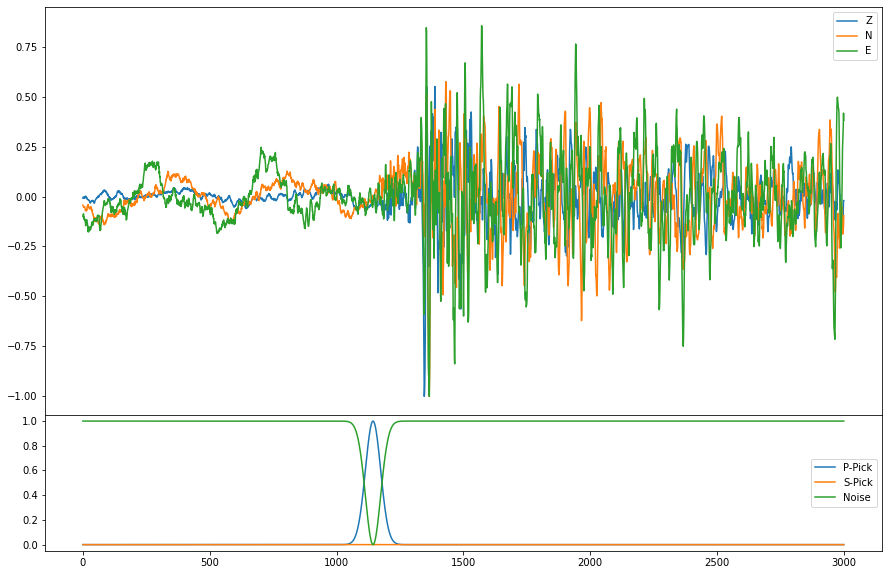

22201


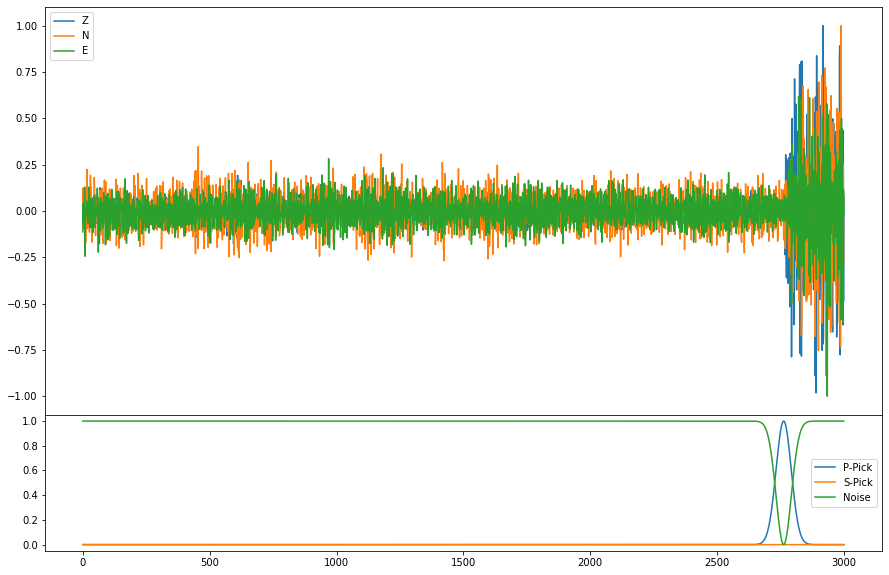

1773


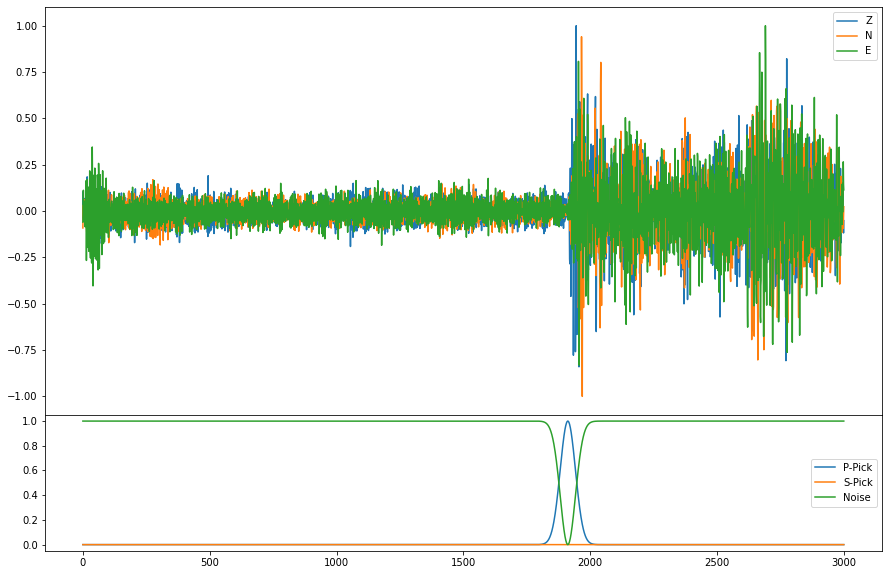

19926


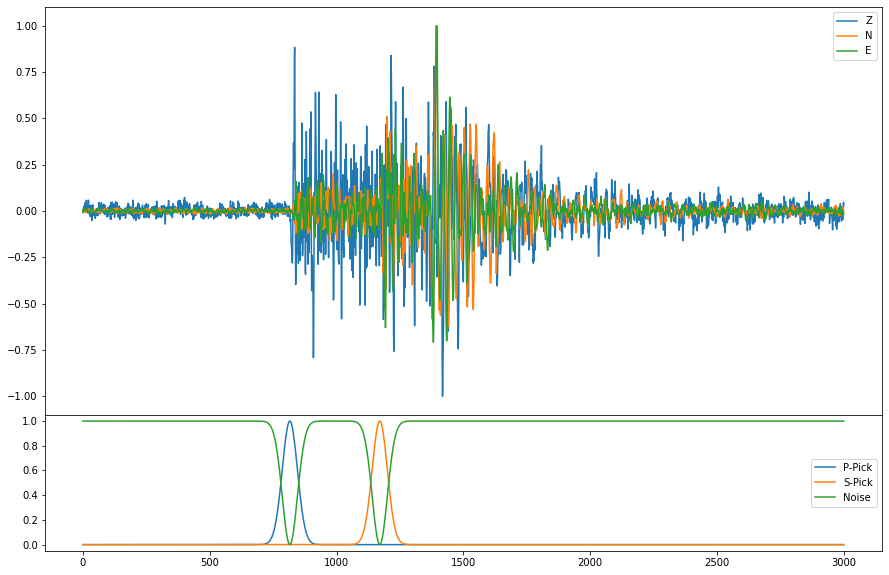

3970


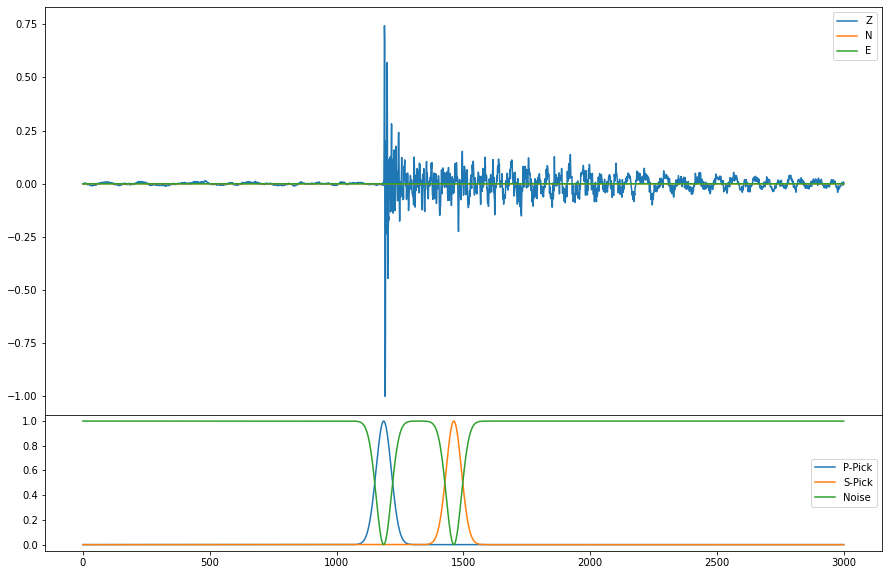

7671


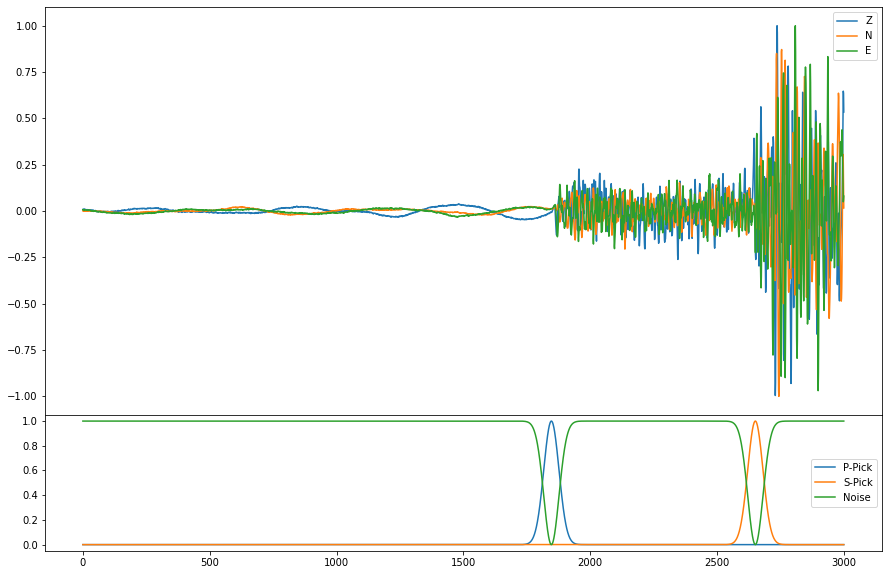

5895


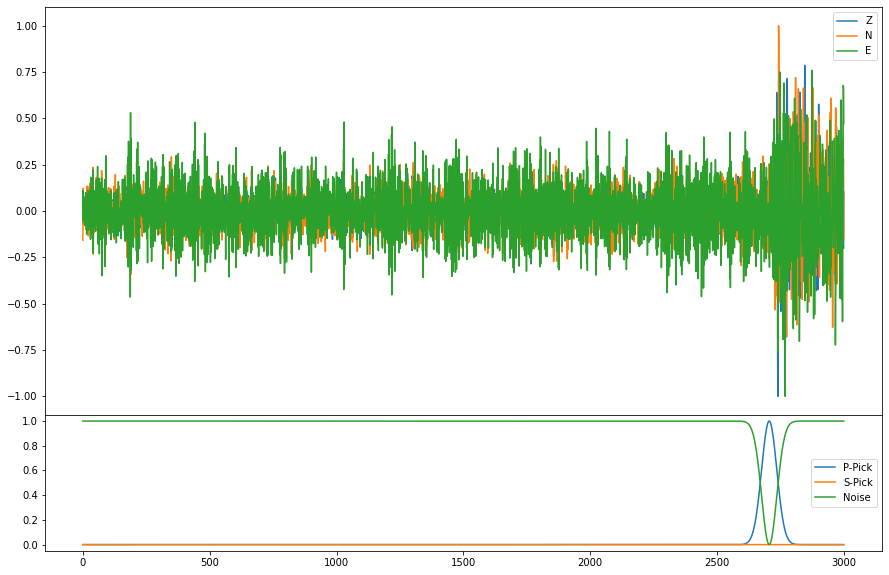

8658


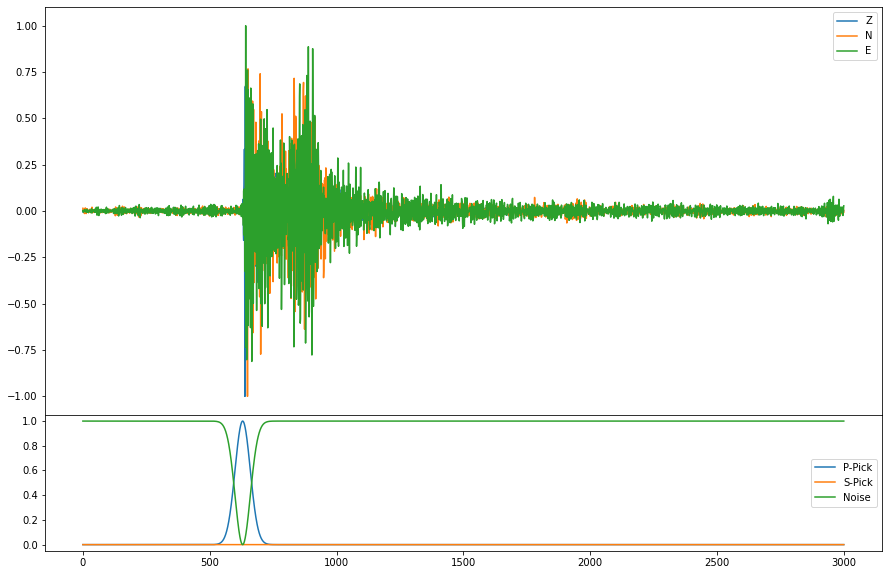

19105


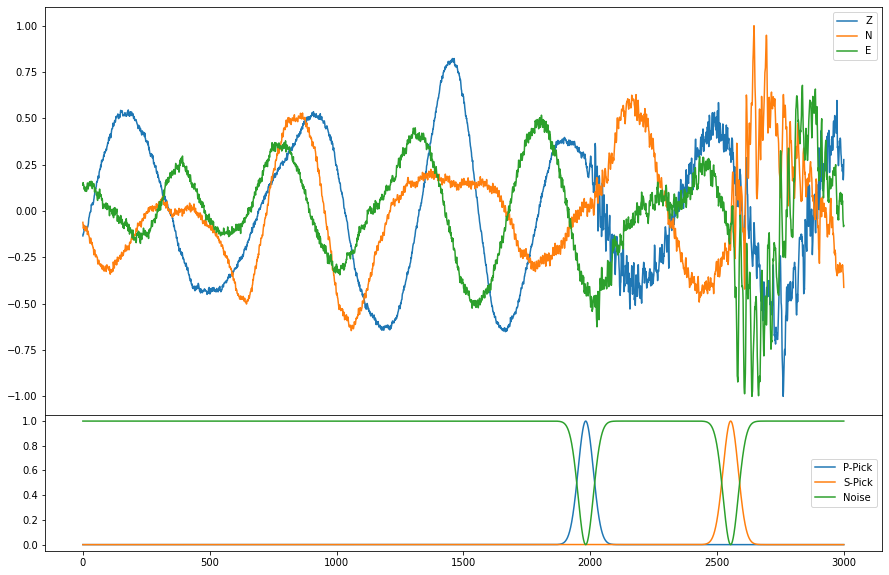

16772


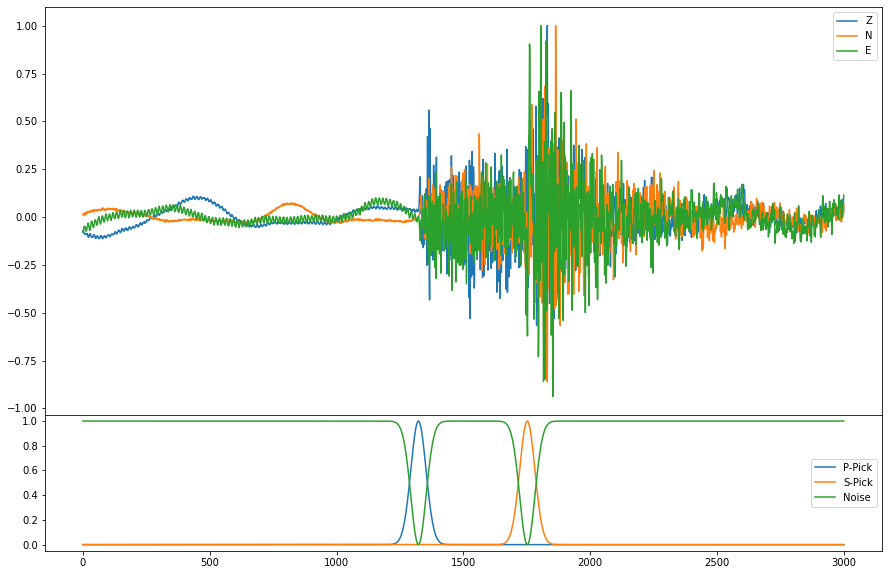

12534


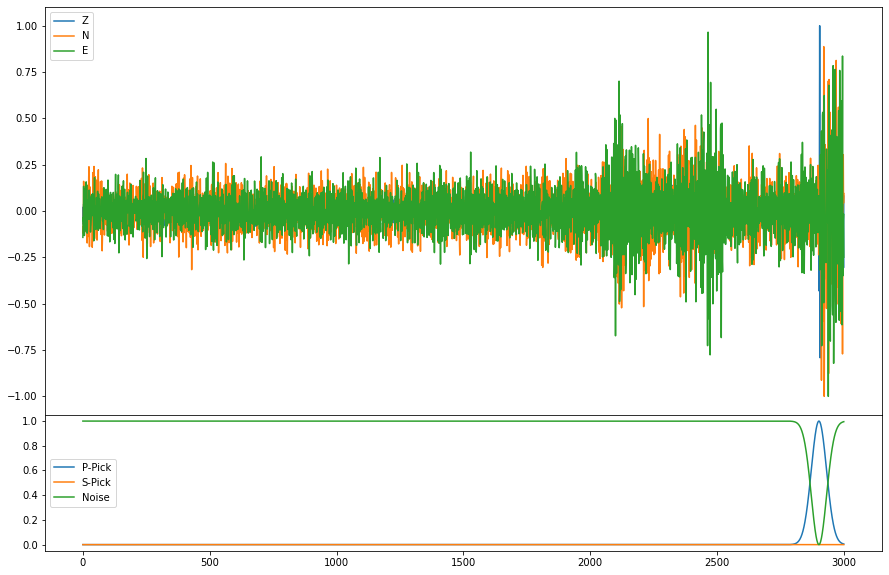

11048


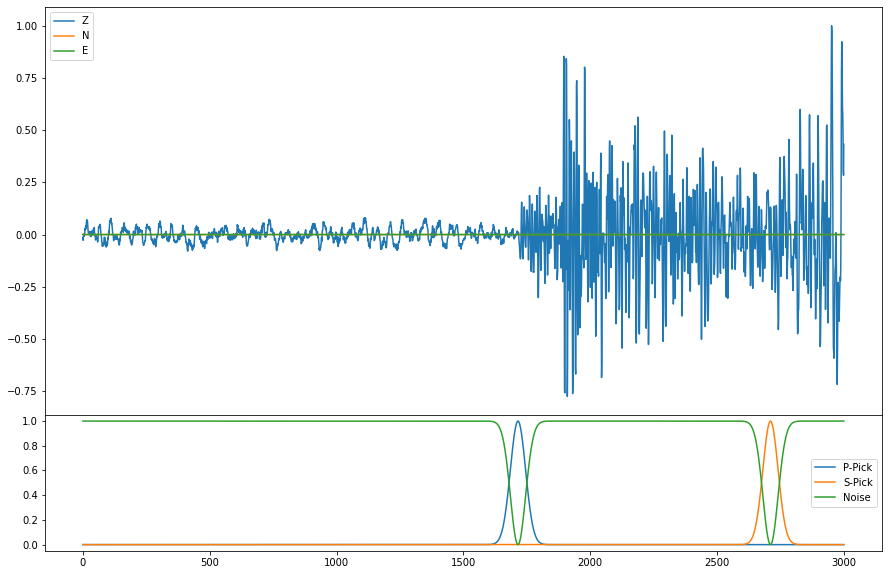

22205


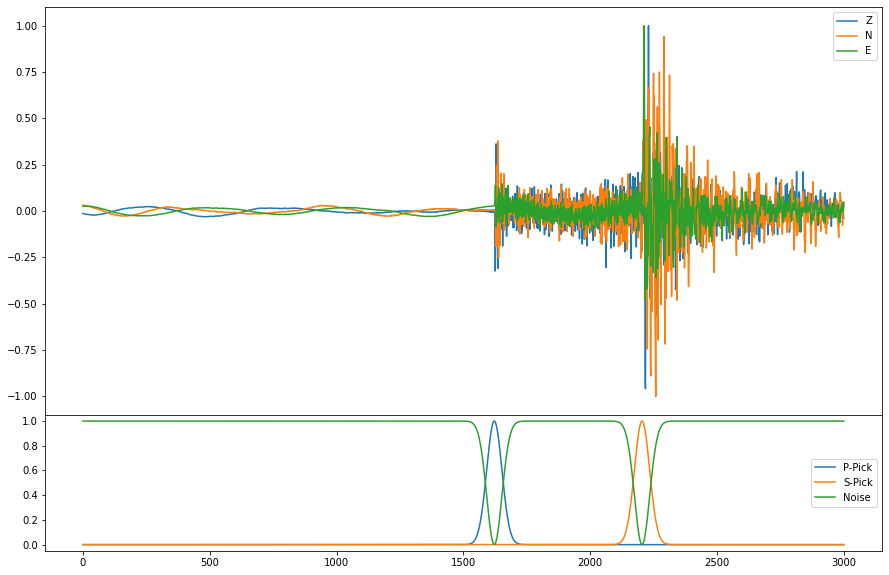

10154


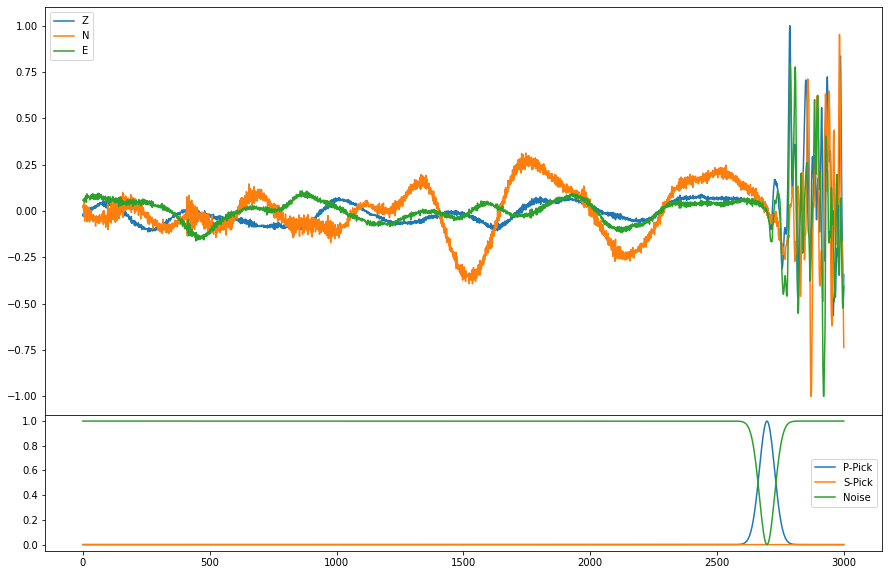

19386


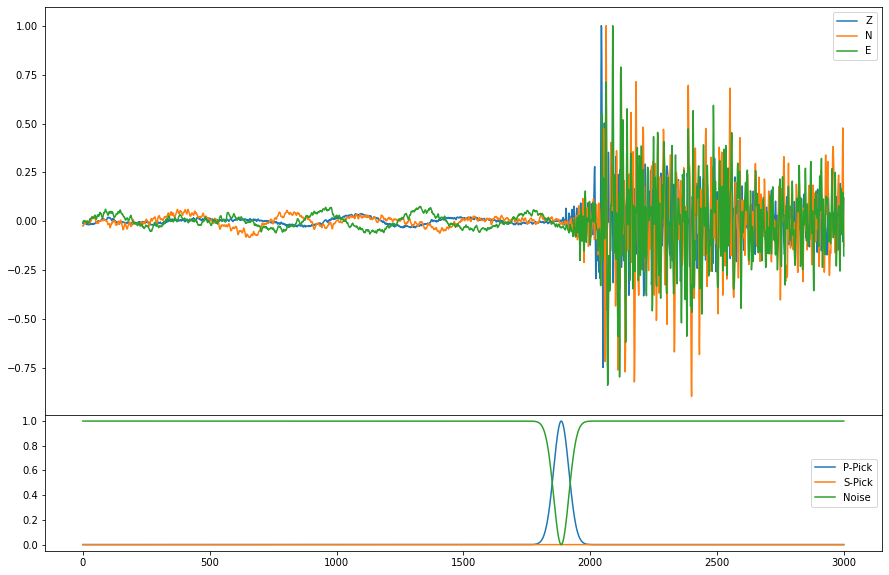

15380


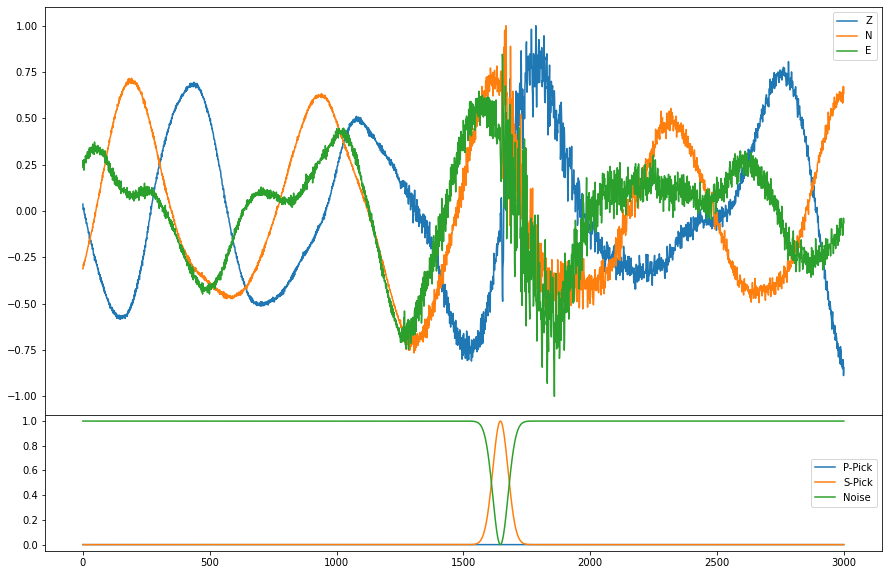

11427


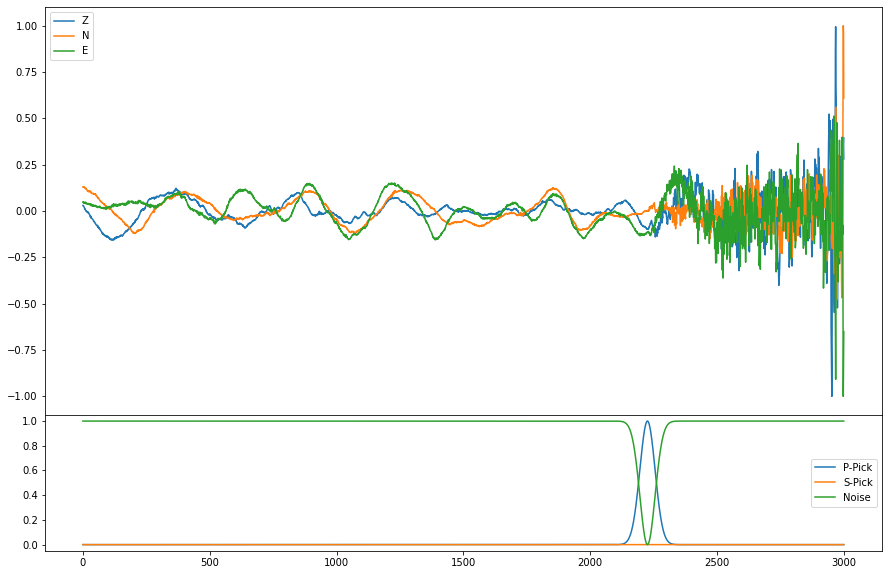

12195


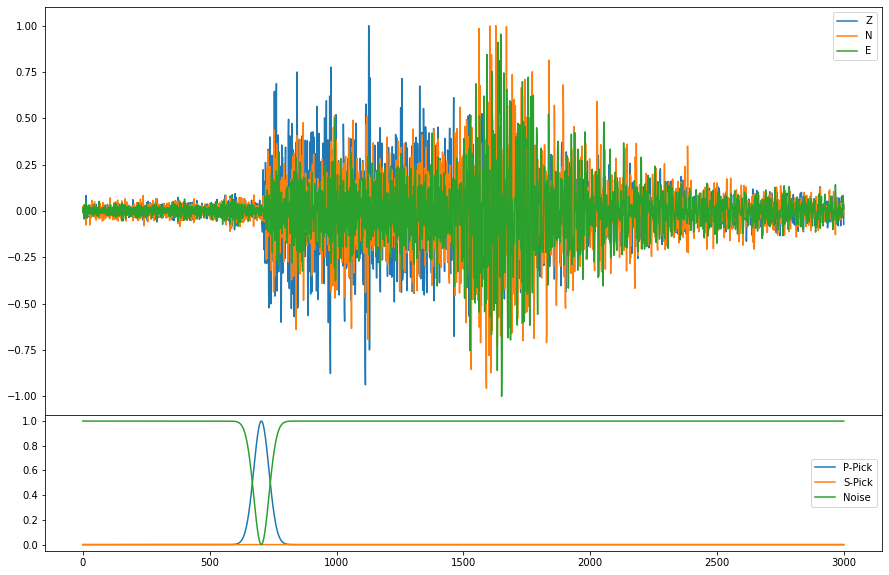

21411


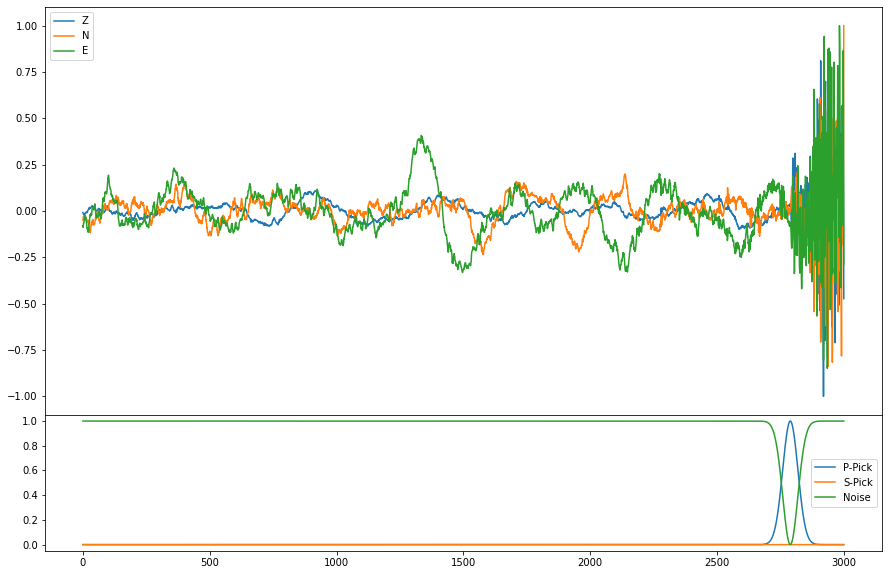

15307


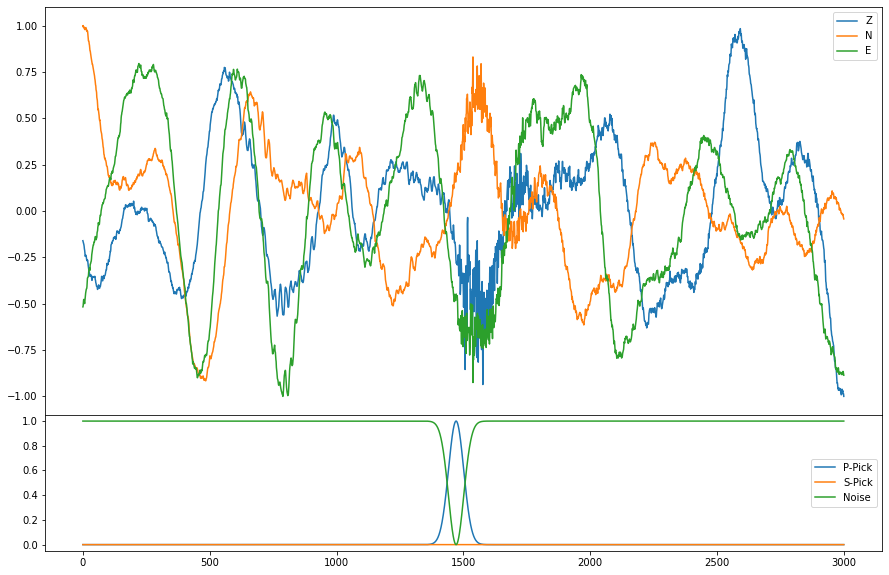

140


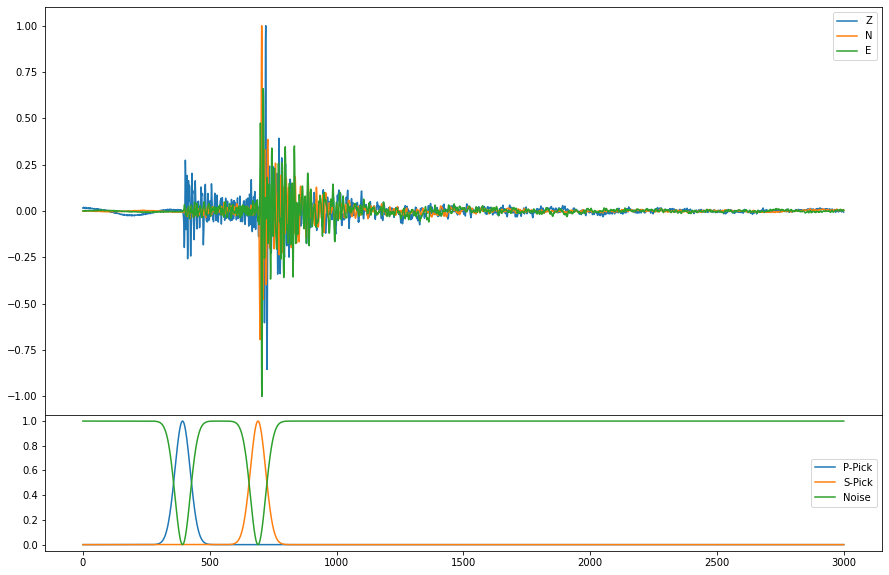

4327


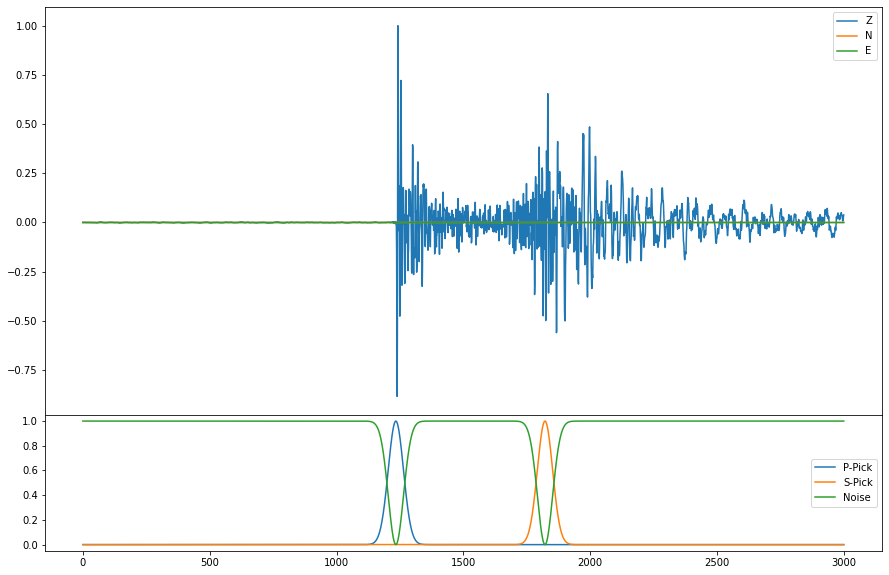

In [8]:
def plot_randos():
  rand_int = np.random.randint(len(train_generator))
  print(rand_int)

  sample = train_generator[rand_int]

  fig = plt.figure(figsize=(15, 10))
  axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [3, 1]})
  axs[0].plot(sample["X"][0], label='Z')
  axs[0].plot(sample["X"][1], label='N')
  axs[0].plot(sample["X"][2], label='E')
  axs[0].legend()
  axs[1].plot(sample["y"][0], label='P-Pick')
  axs[1].plot(sample["y"][1], label='S-Pick')
  axs[1].plot(sample["y"][2], label='Noise')
  axs[1].legend()
  plt.show()
for i in range(25):
  plot_randos()